In [53]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.colors import LogNorm
from astropy.io import fits
import astropy.units as u
import importlib

import statmorph
from statmorph.utils.image_diagnostics import make_figure

import utils.data as datutils
import utils.plots as plots
import utils.image as imutils
%matplotlib inline

In [2]:
import warnings
from pandas.errors import ParserWarning

warnings.simplefilter(action='ignore', category=ParserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['axes.labelsize'] = 13
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["font.family"] = "serif"

# MAH

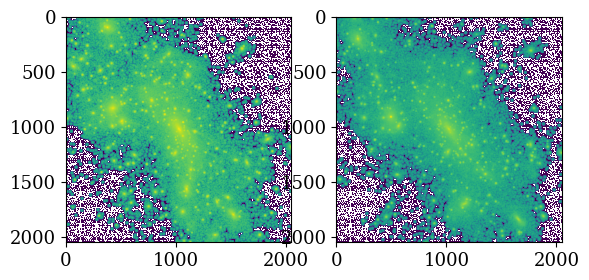

In [11]:
mf = 'data/gadgetx3k_20/maps/OLD_ICs/bcg_0003_125_0.fits'
hdu_list = fits.open(mf)
new_map = hdu_list[0].data

mf = 'data/gadgetx3k_20/maps/first_maps/bcg_0003_125_0.fits'
hdu_list = fits.open(mf)
old_map = hdu_list[0].data

fig, axs = plt.subplots(1, 2)
plots.display_img(old_map, axs[0])
plots.display_img(new_map, axs[1])

In [ ]:
# load dynamical state today
ds_z0 = {}
with open('data/gadgetx3k_20/GadgetX-DS-theory-snap-128.txt') as f:
    for i, x in enumerate(f):
        if i == 0:
            continue
        if i > 20:
            break
        k, v = list(map(int, x.split()))
        ds_z0[k] = v

state = {0: "Relaxed",
         1: "Disturbed"}

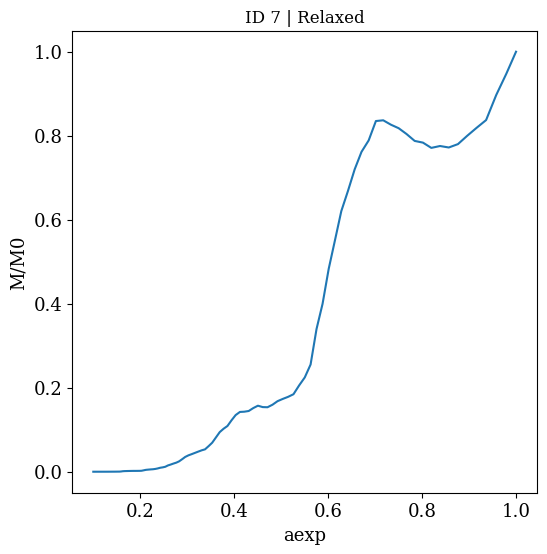

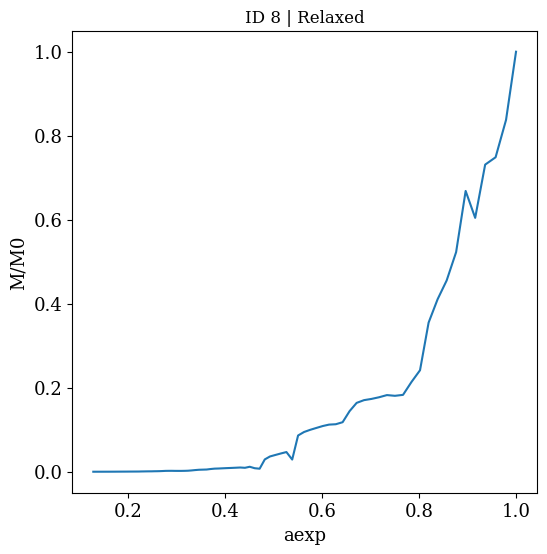

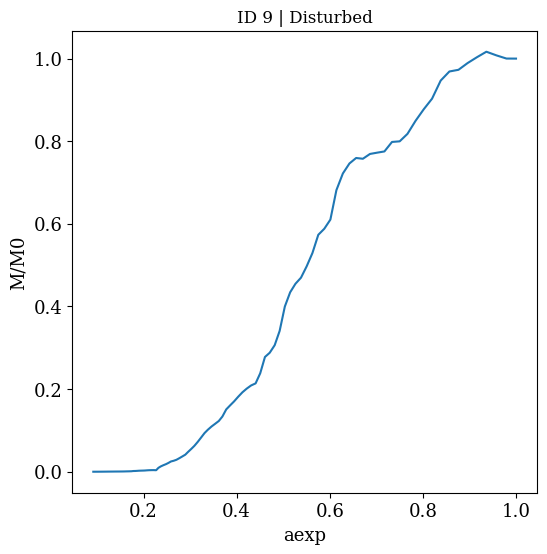

In [ ]:
# display mah
for indx in np.arange(7, 10):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    axs.set_title(f'ID {indx} | {state[ds_z0[indx]]}')
    mah_file = f'data/gadgetx3k_20/AHF_History/NewMDCLUSTER_{str(indx).zfill(4)}_halo_128000000000001.dat'
    mah_df = pd.read_csv(mah_file, sep=r'\s+', index_col=False)

    mm0 = mah_df['Mvir(4)'].values/mah_df['Mvir(4)'][0]
    aexp = 1/(1+mah_df['Redshift(0)'])
    axs.plot(aexp, mm0, label='total')
    axs.set_xlabel('aexp')
    axs.set_ylabel('M/M0')

    plt.show()

# Measure morphologies

In [ ]:
def morph_a():
    morphs_list = []
    for id in np.arange(1, 21):
        try:
            file = fits.open(
                f'data/gadgetx3k_20/maps/bcg_{str(id).zfill(4)}_125_1.fits')
        except FileNotFoundError:
            continue
        print(f"Processing region {id}...")
        image = file[0].data
        center = (int(len(image[1])//2), int(len(image[0])//2))
        # r1 = 50*u.kpc
        # r1 = real2pix(r=r1, map=image)
        # r2 = 1*u.Mpc
        # r2 = real2pix(r=r2, map=image)
        segmap = imutils.annular_mask(image, center, r1=20, r2=409)

        fig, axs = plt.subplots(1, 1)
        plots.display_img(image, axs, mask=segmap)
        plt.show()
        morph = statmorph.source_morphology(image, segmap, gain=2.25)
        print(f'-------region {id} done-------')
        morphs_list.append(morph[0])

    sm_df = datutils.create_morph_df(morphs_list,
                                    name='results/rin_50kpc_rout_1Mpc.csv',
                                    save=False)
    
    return

In [62]:
txt = 'bcg_0082_125'
ind = txt.find('_0')
sub = txt[ind+1:ind+5]
sub.strip('0')

'82'

In [38]:
def load_map(file, map_dir):
    if '.fits' in file:
        map_file = map_dir + file

    try:
        map = fits.open(map_file)
    except FileNotFoundError:
        return None

    map = fits.open(map_file)
    map = map[0].data
    return map

In [87]:
importlib.reload(datutils)

<module 'utils.data' from '/Users/kabelo/clusters/utils/data.py'>

In [92]:
np.arange(5)

array([0, 1, 2, 3, 4])

In [97]:
def morph_c(map_dir):
    finished_ids = [x for x in range(315)]
    morphs_list = []
    files_list = sorted(os.listdir(map_dir))
    for file in files_list:
        id = datutils.find_id(file)
        if id in finished_ids: 
            continue
        else:
            print(f"processing {id}")
            finished_ids.append(id)

        map = load_map(file, map_dir)
        if map is None: continue

        radius = datutils.real2pix(r=1*u.Mpc, map=map)
        center = (int(len(map[1])//2), int(len(map[0])//2))
        segmap = imutils.circular_segmap(map, center, radius=radius)
        morph = statmorph.source_morphology(map, segmap, gain=2.25)
        morphs_list.append((morph[0], id))

        print(f'{file} done')
        if len(morphs_list)%10 == 0:
            sm_df = datutils.create_morph_df(morphs_list,
                                            name=f'results/gadgetx3k_{len(morphs_list)}_1Mpc.csv',
                                            save=True)
            
    return

In [98]:
map_dir = 'data/gadgetx3k_20/maps/OLD_ICs/'
morph_c(map_dir)

processing 315


bcg_0315_125_0.fits done
processing 316


bcg_0316_125_0.fits done
processing 317
bcg_0317_125_0.fits done
processing 318


bcg_0318_125_0.fits done
processing 319
bcg_0319_125_0.fits done
processing 321


bcg_0321_125_0.fits done
processing 323
bcg_0323_125_0.fits done


In [61]:
morph

# Correlations

## SM + MAH

In [ ]:
sm_df = pd.read_csv('results/los_all.csv')
sm_df.columns

In [ ]:
sm_df.drop(columns=['Unnamed: 0', 'sky_mean', 'sky_median',
           'sky_sigma', 'flag', 'flag_sersic', 'flux_circ', 'flux_ellip', 
            'runtime', 'sn_per_pixel'], inplace=True)
sm_df.columns

In [ ]:
mah_df_list = []
for file in os.listdir('data/gadgetx3k_20/AHF_History/'):
    if '.dat' not in file:
        continue
    elif file == 'NewMDCLUSTER_0013_halo_128000000000001.dat':
            continue
    elif file == 'NewMDCLUSTER_0014_halo_128000000000001.dat':
            continue
    mah_file = 'data/gadgetx3k_20/AHF_History/' + file
    mah_df = pd.read_csv(mah_file, sep=r'\s+', index_col=False)
    mm0 = mah_df['Mvir(4)'].values/mah_df['Mvir(4)'][0]
    mm0 = pd.DataFrame(mm0)
    mm0.rename(columns={0: 'M/M0'}, inplace=True)
    mm0['Redshift'] = mah_df['Redshift(0)']
    mah_df_list.append(mm0)

In [ ]:
corrs_list = []
z_list = []
for z in mah_df_list[0]['Redshift']:
    if z <  0.06872:    #SM measurements done at snap 125
        continue
    mah_df = pd.DataFrame(columns=['M/M0'])

    for region in range(18):
        row = mah_df_list[region].loc[mah_df_list[region]
                                      ['Redshift'] == z, ['M/M0']]
        if not row.empty:
            mah_df = pd.concat([mah_df, row], ignore_index=True)

    if mah_df.shape[0] != sm_df.shape[0]:
        # print(
        #     f"Skipping redshift {z}: mismatched rows {mah_df.shape[0]} vs {sm_df.shape[0]}")
        continue

    df = pd.concat([mah_df.reset_index(drop=True),
                   sm_df.reset_index(drop=True)], axis=1)
    corrs = df.corr(method='spearman')
    corrs_list.append(corrs)
    z_list.append(z)
z_array = np.array(z_list)

In [ ]:
aexp = 1/(1+z_array)
sersic_n = [df.loc['sersic_n', 'M/M0'] for df in corrs_list]
rhalf_ellip = [df.loc['rhalf_ellip', 'M/M0'] for df in corrs_list]
gini = [df.loc['Gini', 'M/M0'] for df in corrs_list]
rpetro_ellip = [df.loc['rpetro_ellip', 'M/M0'] for df in corrs_list]
orientation_asymmetry = [
    df.loc['orientation_asymmetry', 'M/M0'] for df in corrs_list]
rpetro_circ = [df.loc['rpetro_circ', 'M/M0'] for df in corrs_list]
rhalf_circ = [df.loc['rhalf_circ', 'M/M0'] for df in corrs_list]
m20 = [df.loc['M20', 'M/M0'] for df in corrs_list]              # stronger corr
fgm20 = [df.loc['F(G, M20)', 'M/M0'] for df in corrs_list]
sgm20 = [df.loc['S(G, M20)', 'M/M0'] for df in corrs_list]
conc = [df.loc['C', 'M/M0'] for df in corrs_list]
asym = [df.loc['A', 'M/M0'] for df in corrs_list]
smooth = [df.loc['S', 'M/M0'] for df in corrs_list]

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
axs.set_title('Statmorph Correlations')
axs.plot(aexp, sersic_n, label='sersic_n')
axs.plot(aexp, rhalf_ellip, label='r1/2')
axs.plot(aexp, gini, label='gini')
axs.set_xlabel('Scale Factor a = 1/(1+z)')
axs.set_ylabel(r'$\rho_s (SM_{a=0.94}, M/M_0)$')
axs.grid()
plt.legend()
plt.show()

## SM + DS

In [ ]:
# using new ICs
ds_df = pd.read_csv('data/gadgetx3k_20/snap_125_18.dyn', header=1, sep=r'\s+')
ds_df.drop(columns=['region'], inplace=True)
display(ds_df)
display(sm_df)

In [ ]:
df = pd.concat([ds_df, sm_df], axis=1)
df

In [ ]:
corrs = df.corr(method='spearman')
plots.plot_corr_matrix(corrs)

In [ ]:
# using old ICs

rds_today = 'data/gadgetx3k_20/G3X_progenitors/DS_G3X_snap_125_center-cluster_progenitors.txt'
rds_today = pd.read_csv(rds_today, sep=r'\s+')
rds_today.drop(columns=['rID[0]', 'Hid[1]', 'DS_200[2]', 'DS_500[7]'], 
               inplace=True)
rds_today = rds_today.sample(len(sm_df))


In [ ]:
# ds_df = rds_today.drop(labels=[14, 15], axis=0)
df = pd.concat([rds_today, sm_df], axis=1)
corrs = df.corr(method='spearman')
plots.plot_corr_matrix(corrs)